In [2]:
#Changes from example 2 - creating a class based structure to make web-app building easier

In [1]:
import importlib
import numpy as np
importlib.reload(np)
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import fft
!pip install voila
!jupyter labextension install @voila-dashboards/jupyterlab-preview

/srv/conda/lib/python3.11/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)


  Using cached voila-0.5.11-py3-none-any.whl.metadata (9.4 kB)
  Using cached websockets-15.0.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached voila-0.5.11-py3-none-any.whl (4.5 MB)
Using cached websockets-15.0.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (182 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [voila]32m1/2 [voila]
(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/srv/conda/lib/python3.11/site-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/srv/conda/lib/python3.11/site-packages/jupyterlab/debuglo

In [9]:
class TDGLSimulation:
    def __init__(self,
                 kappa=5.0,
                 H=0.3,
                 dt=0.005,
                 resolution=100,
                 points_per_plot_unit=4,
                 psi_damping=1.0,
                 A_damping=8.0,
                 A_update_interval=3,
                 max_dA=0.1,
                 vortex_seeding=False,
                 evolve_A_flag=True,
                 initial_psi_amp=0.8,
                 noise_strength=0.05,
                 rng_seed=42):

        np.random.seed(rng_seed)

        # --- Store Simulation Parameters ---
        self.kappa = kappa
        self.H = H
        self.dt = dt
        self.resolution = resolution
        self.points_per_plot_unit = points_per_plot_unit
        self.grid_size = resolution / points_per_plot_unit
        self.Lx = self.Ly = self.grid_size
        self.Nx = self.Ny = self.resolution
        
        # --- Store Damping & Control Parameters ---
        self.psi_damping = psi_damping
        self.A_damping = A_damping
        self.A_update_interval = A_update_interval
        self.max_dA = max_dA
        self.evolve_A_flag = evolve_A_flag
        self.vortex_seeding = vortex_seeding
        self.initial_psi_amp = initial_psi_amp
        self.noise_strength = noise_strength

        # --- Setup Grid ---
        self.dx, self.dy, self.x, self.y, self.X, self.Y, self.KX, self.KY = self._setup_grid()

        # --- Initialize State Variables ---
        self.step_count = 0
        self.psi = np.ones((self.Ny, self.Nx), dtype=complex) * self.initial_psi_amp
        self.psi += self.noise_strength * (np.random.randn(self.Ny, self.Nx) + 1j * np.random.randn(self.Ny, self.Nx))

        # --- Added some random pinning to decrease critical current density ---
        self.pinning_density = 0.075
        self.pinning_strength = 4
        rng = np.random.default_rng(rng_seed)
        self.pinning = (rng.random((self.Ny, self.Nx)) < self.pinning_density).astype(float)
        
        # Magnetic vector potential in Landau gauge
        self.H = self.external_field(t=0 * dt, H0=H, ramp_rate=0.0, H_amp=0.0, omega=0.0, mode='constant')
        self.Ax = np.zeros_like(self.X)
        self.Ay = self.H * self.X

        # --- (Optional) Seed Vortices ---
        if self.vortex_seeding:
            self._seed_vortices()
            
        print("TDGLSimulation instance created.")
        self.print_parameters()

    
    def external_field(self, t, H0=0.5, ramp_rate=0.0, H_amp=0.0, omega=0.0, mode='constant'):
        if mode == 'linear_ramp':
            return H0 + ramp_rate * t
        if mode == 'sin':
            return H0 + H_amp * np.sin(omega * t)
        if mode == 'combined':
            return H0 + ramp_rate * t + H_amp * np.sin(omega * t)
        return H0
        
    def print_parameters(self):
        print(f"Simulation Parameters:\nκ = {self.kappa}, dt = {self.dt}, H = {self.H}")
        print(f"Resolution: {self.resolution}, Points per plot unit: {self.points_per_plot_unit}")
        print(f"Vortex seeding is {'on' if self.vortex_seeding else 'off'}, and vector potential evolution is {'on' if self.evolve_A_flag else 'off'}")
        print(f"ψ damping: {self.psi_damping}")
        if self.evolve_A_flag:
            print(f"A damping: {self.A_damping}, A update interval: {self.A_update_interval}, Max change in A per timestep: {self.max_dA}")
        print(f"Initial Conditions: ψ_init = {self.initial_psi_amp}, noise = {self.noise_strength}\n")

    def _setup_grid(self):
        """Creates the spatial and Fourier-space grids."""
        x = np.linspace(0, self.Lx, self.Nx, endpoint=True)
        y = np.linspace(0, self.Ly, self.Ny, endpoint=True)
        dx = x[1] - x[0]
        dy = y[1] - y[0]
        X, Y = np.meshgrid(x, y)

        d0 = 1.0
        noise_strength = 0.2
        rng = np.random.default_rng(42)
        d = d0 * (1.0 + noise_strength * rng.standard_normal(size=X.shape))
        d = np.clip(d, 0.2 * d0, None)   # minimum thickness floor
        self.d = d

        kx = 2 * np.pi * fft.fftfreq(self.Nx, dx)
        ky = 2 * np.pi * fft.fftfreq(self.Ny, dy)
        KX, KY = np.meshgrid(kx, ky)
        return dx, dy, x, y, X, Y, KX, KY

    def _seed_vortices(self):
        """Initializes psi with a hexagonal vortex lattice."""
        print("Seeding vortices...")
        vortex_positions = []
        core_size_relative = 1.5  # Arbitrary vortex scale
        
        # Estimate vortex spacing for hexagonal lattice
        a_vortex = np.sqrt(2 * np.sqrt(3) / self.H)
        n_x = int(self.Lx / a_vortex) + 1
        n_y = int(self.Ly / (a_vortex * np.sqrt(3) / 2)) + 1

        # Create hexagonal lattice
        for j in range(n_y):
            for i in range(n_x):
                x_pos = i * a_vortex + 0.5 * a_vortex * (j % 2)
                y_pos = j * a_vortex * np.sqrt(3) / 2
                
                if 0.5 < x_pos < self.Lx - 0.5 and 0.5 < y_pos < self.Ly - 0.5:
                    vortex_positions.append((x_pos, y_pos))

        # Seed vortices
        for vx, vy in vortex_positions:
            phase_wind = np.arctan2(self.Y - vy, self.X - vx)
            dist = np.sqrt((self.X - vx)**2 + (self.Y - vy)**2)
            
            vortex_profile = np.tanh(dist / (core_size_relative * self.dx))
            self.psi *= vortex_profile * np.exp(1j * phase_wind)
        
        print(f"Seeded: {len(vortex_positions)} vortices in hexagonal pattern\n")

    # --- Core Computational Methods (Internal) ---

    def _laplacian_cov_2D_fd(self, psi, Ax, Ay):
        """Covariant finite-difference 2D Laplacian"""
        Ax_xp = 0.5 * (Ax + np.roll(Ax, -1, axis=1))
        Ax_xm = 0.5 * (Ax + np.roll(Ax, 1, axis=1))
        Ay_yp = 0.5 * (Ay + np.roll(Ay, -1, axis=0))
        Ay_ym = 0.5 * (Ay + np.roll(Ay, 1, axis=0))
        
        psi_xp = np.roll(psi, -1, axis=1) * np.exp(-1j * Ax_xp * self.dx)
        psi_xm = np.roll(psi, 1, axis=1) * np.exp(1j * Ax_xm * self.dx)
        psi_yp = np.roll(psi, -1, axis=0) * np.exp(-1j * Ay_yp * self.dx)
        psi_ym = np.roll(psi, 1, axis=0) * np.exp(1j * Ay_ym * self.dx)
        
        lap = (psi_xp + psi_xm + psi_yp + psi_ym - 4 * psi) / self.dx**2
        return lap

    def _covariant_derivative_2D_fd(self, psi, Ax, Ay):
        """Covariant finite difference derivative in 2D using FFT."""
        psi_k = fft.fft2(psi)
        dpsi_dx = fft.ifft2(1j * self.KX * psi_k)
        dpsi_dy = fft.ifft2(1j * self.KY * psi_k)
        
        return dpsi_dx - 1j * Ax * psi, dpsi_dy - 1j * Ay * psi

    def _supercurrent(self, psi, Ax, Ay):
        """Calculate supercurrent density J = Im[ψ*(D_μ ψ)]"""
        Dx_psi, Dy_psi = self._covariant_derivative_2D_fd(psi, Ax, Ay)
        
        Jx = np.imag(np.conj(psi) * Dx_psi)
        Jy = np.imag(np.conj(psi) * Dy_psi)

        Jx = Jx * self.d
        Jy = Jy * self.d
        
        return Jx, Jy

    def _curl_2D_nonperiodic(self, Ax, Ay):
        """Nonperiodic 2D finite difference curl."""
        Ny, Nx = Ax.shape
        dAy_dx = np.zeros_like(Ay)
        dAx_dy = np.zeros_like(Ax)

        dAy_dx[:, 1:-1] = (Ay[:, 2:] - Ay[:, :-2]) / (2 * self.dx)
        dAx_dy[1:-1, :] = (Ax[2:, :] - Ax[:-2, :]) / (2 * self.dx)

        dAy_dx[:, 0] = (Ay[:, 1] - Ay[:, 0]) / self.dx
        dAy_dx[:, -1] = (Ay[:, -1] - Ay[:, -2]) / self.dx

        dAx_dy[0, :] = (Ax[1, :] - Ax[0, :]) / self.dx
        dAx_dy[-1, :] = (Ax[-1, :] - Ax[-2, :]) / self.dx

        return dAy_dx - dAx_dy

    def _evolve_psi(self):
        """Evolve order parameter, updating self.psi in-place."""
        nonlinear_term = (1 - np.abs(self.psi)**2) * self.psi
        laplacian_term = self._laplacian_cov_2D_fd(self.psi, self.Ax, self.Ay)

        dpsi_dt = (nonlinear_term + laplacian_term) / self.psi_damping
        dpsi_dt -= self.pinning_strength * self.pinning * self.psi
        self.psi += self.dt * dpsi_dt
    
    def _evolve_A(self):
        """Evolve vector potential, updating self.Ax/Ay in-place."""
        Jx, Jy = self._supercurrent(self.psi, self.Ax, self.Ay)
        
        Bz = self._curl_2D_nonperiodic(self.Ax, self.Ay)
        
        # Periodic finite-difference for derivatives of Bz
        dBz_dx = (np.roll(Bz, -1, axis=1) - np.roll(Bz, 1, axis=1)) / (2 * self.dx)
        dBz_dy = (np.roll(Bz, -1, axis=0) - np.roll(Bz, 1, axis=0)) / (2 * self.dx)
        
        dAx_dt = (self.d * Jx - self.kappa**2 * dBz_dy) / self.A_damping
        dAy_dt = (self.d * Jy + self.kappa**2 * dBz_dx - self.H) / self.A_damping
        
        # Clip change to prevent instability
        dAx_dt = np.clip(dAx_dt, -self.max_dA, self.max_dA)
        dAy_dt = np.clip(dAy_dt, -self.max_dA, self.max_dA)
        
        # Scale dt by update interval
        dt_A = self.dt * self.A_update_interval
        
        self.Ax += dt_A * dAx_dt
        self.Ay += dt_A * dAy_dt
        
    def compute_critical_current_density(self):
        Jx, Jy = self._supercurrent(self.psi, self.Ax, self.Ay)
        J = np.sqrt(Jx**2 + Jy**2)
        return np.mean(J)

    def measure_Jc_at_B(self, B, N_eq=800, relax_steps=20, dk=1e-4, k_max=1.0, V_thresh=1e-4):
        # set field (assumes external_field uses self.H or similar)
        self.H = B
        # equilibrate
        for _ in range(N_eq):
            # run one TDGL step (use your existing update call)
            self._tdgl_step()      # or whatever step function your class uses
        # transport ramp via uniform phase gradient along x
        x = np.linspace(0, self.Lx, self.Nx, endpoint=False)
        Xgrid = np.tile(x, (self.Ny, 1))
        k = 0.0
        while k <= k_max:
            # apply phase gradient (gauge neutral way): multiply psi by exp(i*k*x)
            self.psi *= np.exp(1j * dk * Xgrid)   # incremental apply; dk small
            # relax a bit
            for _ in range(relax_steps):
                self._tdgl_step()
            # measure voltage surrogate: time derivative of phase averaged
            phase_now = np.angle(self.psi)
            # take a short time-centered derivative by doing one more step
            self._tdgl_step()
            phase_next = np.angle(self.psi)
            dphidt = np.abs((phase_next - phase_now) / self.dt)
            V = np.mean(dphidt)
            # measure mean current density from your supercurrent function
            Jx, Jy = self._supercurrent(self.psi, self.Ax, self.Ay)
            J_mean = np.mean(np.abs(Jx))
            if V > V_thresh:
                return J_mean  # Jc in sim units
            k += dk
        # if no threshold reached
        return J_mean

    # --- Estimate number of vortices in film ---
    def count_vortices(self):
        psi = self.psi
        phase = np.angle(psi)
        Ny, Nx = phase.shape
        vortex_count = 0

        for y in range(Ny - 1):
            for x in range(Nx - 1):
            # Extract phases around the plaquette
                p00 = phase[y, x]
                p10 = phase[y, x+1]
                p11 = phase[y+1, x+1]
                p01 = phase[y+1, x]

            # Compute phase differences with wrapping
                d1 = np.angle(np.exp(1j*(p10 - p00)))
                d2 = np.angle(np.exp(1j*(p11 - p10)))
                d3 = np.angle(np.exp(1j*(p01 - p11)))
                d4 = np.angle(np.exp(1j*(p00 - p01)))

                winding = (d1 + d2 + d3 + d4) / (2*np.pi)

                if abs(round(winding)) == 1:
                    vortex_count += 1
        area = self.Nx * self.Ny * self.dx**2
        density = vortex_count / area
        
        return vortex_count, density

    # --- Public API Methods ---

    def update_one_step(self):
        """
        This is the main public method. 
        Call this in a loop to run the simulation.
        """
        self._evolve_psi()
        
        if self.evolve_A_flag and self.step_count % self.A_update_interval == 0:
            self._evolve_A()
        
        self.step_count += 1
        return self.step_count

    def set_parameters(self, H=None, kappa=None, psi_damping=None, A_damping=None):
        """
        Safely update simulation parameters in real-time.
        This is what your Voila sliders will call.
        """
        if H is not None:
            self.H = H
        if kappa is not None:
            self.kappa = kappa
        if psi_damping is not None:
            self.psi_damping = psi_damping
        if A_damping is not None:
            self.A_damping = A_damping

    def get_density(self):
        """Returns the current superconducting density |ψ|² for plotting."""
        return np.abs(self.psi)**2

    def get_phase(self):
        """Returns the current phase of ψ for plotting."""
        return np.angle(self.psi)
    
    def get_current_time(self):
        """Returns the current simulation time."""
        return self.step_count * self.dt
    
    def check_instability(self):
        """Checks for non-physical values."""
        max_psi = np.max(np.abs(self.psi))
        if np.isnan(max_psi) or max_psi > 2.0:
            return True
        return False

TDGLSimulation instance created.
Simulation Parameters:
κ = 5.0, dt = 0.005, H = 0.3
Resolution: 100, Points per plot unit: 4
Vortex seeding is off, and vector potential evolution is on
ψ damping: 1.0
A damping: 8.0, A update interval: 3, Max change in A per timestep: 0.1
Initial Conditions: ψ_init = 0.8, noise = 0.05

Starting Batch Simulation (replicates original script)...
t=0.0 | |ψ|: min=0.540, avg=0.738, max=0.933 | Time elapsed for steps 0 to 0: 0.00s
t=5.0 | |ψ|: min=0.000, avg=0.098, max=0.556 | Time elapsed for steps 0 to 1000: 2.23s
t=10.0 | |ψ|: min=0.003, avg=0.328, max=0.715 | Time elapsed for steps 1000 to 2000: 2.22s
t=15.0 | |ψ|: min=0.010, avg=0.521, max=0.879 | Time elapsed for steps 2000 to 3000: 2.25s
t=20.0 | |ψ|: min=0.011, avg=0.558, max=0.869 | Time elapsed for steps 3000 to 4000: 2.24s
t=25.0 | |ψ|: min=0.005, avg=0.567, max=0.864 | Time elapsed for steps 4000 to 5000: 2.19s
t=30.0 | |ψ|: min=0.015, avg=0.581, max=0.886 | Time elapsed for steps 5000 to 6000: 2

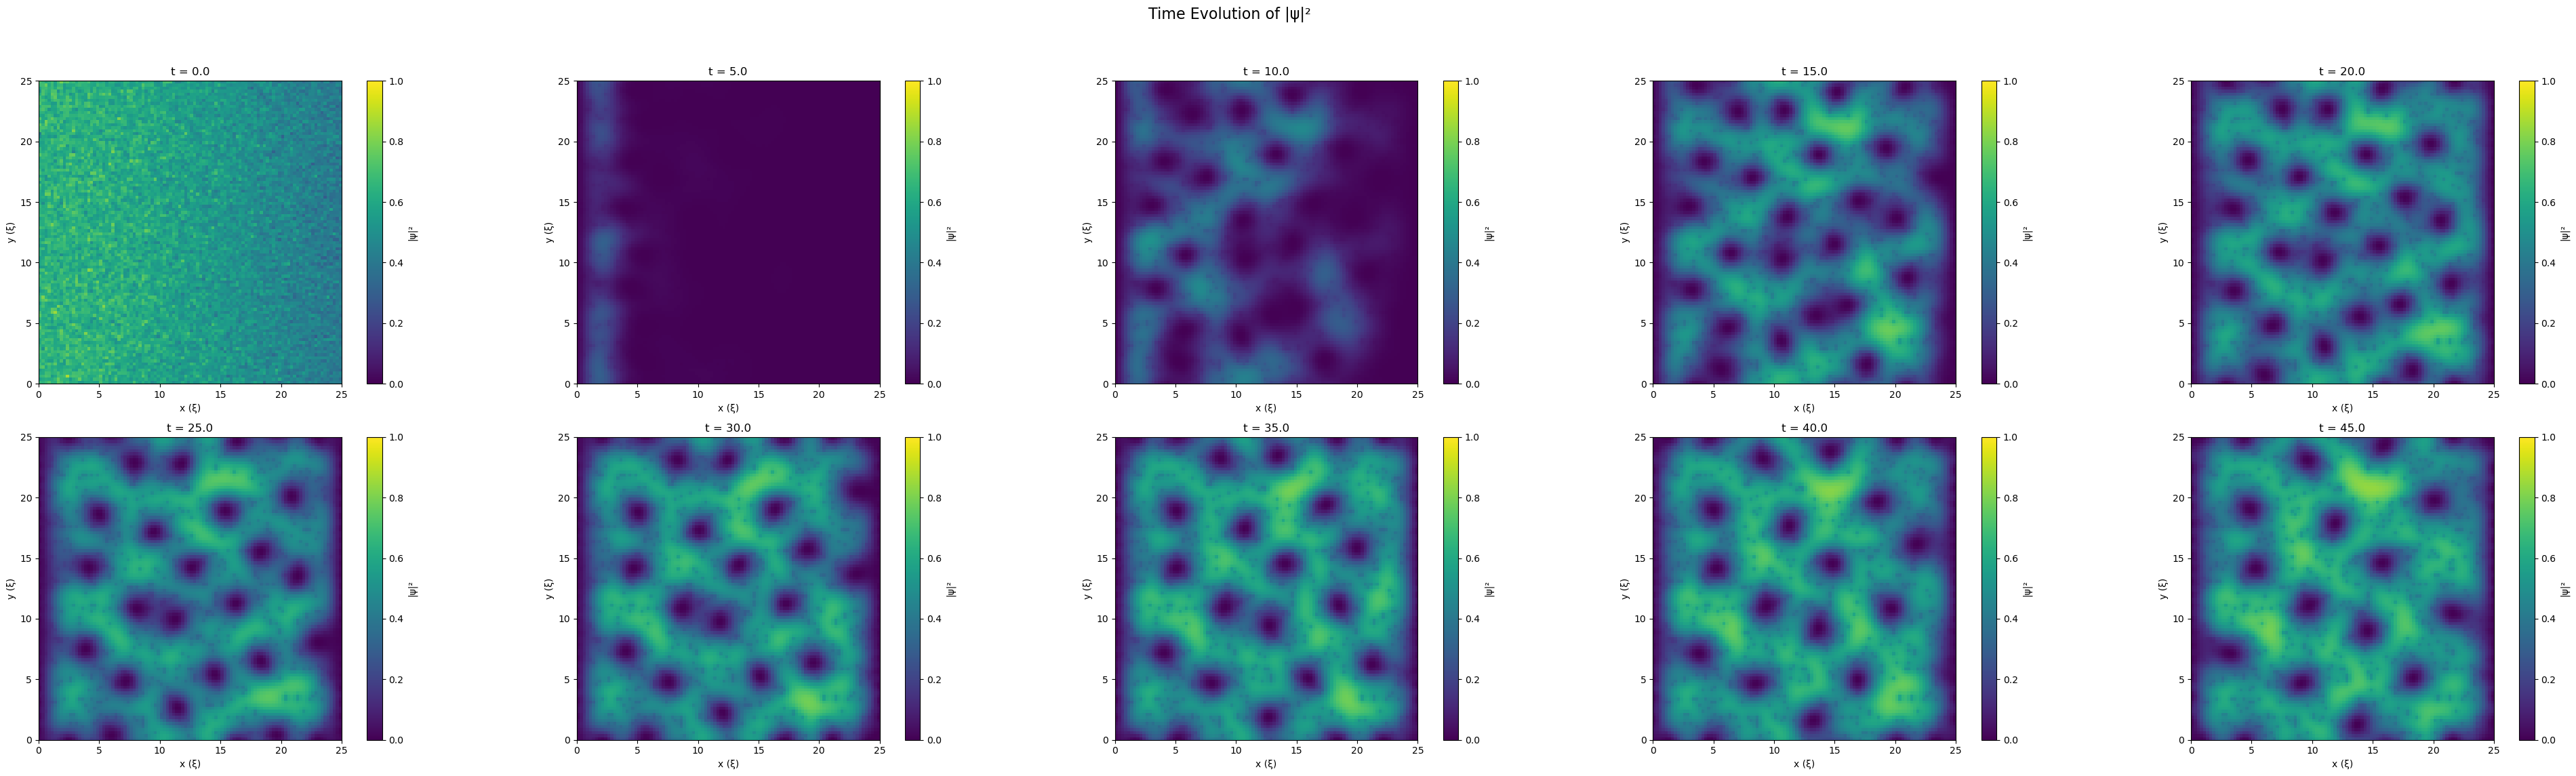

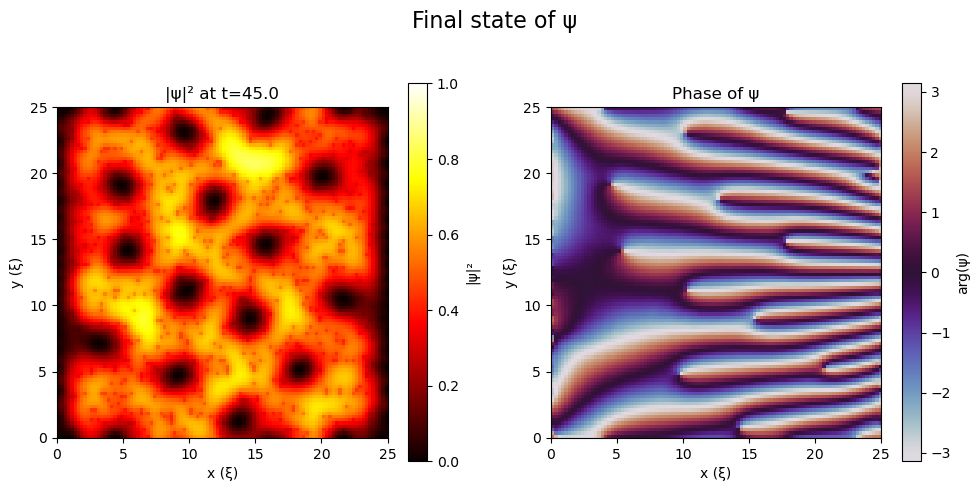


Running TDGL for H = 0.0 T
TDGLSimulation instance created.
Simulation Parameters:
κ = 5.0, dt = 0.005, H = 0.0
Resolution: 100, Points per plot unit: 4
Vortex seeding is off, and vector potential evolution is on
ψ damping: 1.0
A damping: 8.0, A update interval: 3, Max change in A per timestep: 0.1
Initial Conditions: ψ_init = 0.8, noise = 0.05

Raw simulation Jc at H=0.0 → 0.0953205146083056
H=0.0 → Jc=0.09532, vortices=0, density=0.0000

Full Jc_list (raw simulation units):
[np.float64(0.0953205146083056)]

Running TDGL for H = 0.024308279171488197 T
TDGLSimulation instance created.
Simulation Parameters:
κ = 5.0, dt = 0.005, H = 0.024308279171488197
Resolution: 100, Points per plot unit: 4
Vortex seeding is off, and vector potential evolution is on
ψ damping: 1.0
A damping: 8.0, A update interval: 3, Max change in A per timestep: 0.1
Initial Conditions: ψ_init = 0.8, noise = 0.05

Raw simulation Jc at H=0.024308279171488197 → 0.12986380255729346
H=0.024308279171488197 → Jc=0.12986,

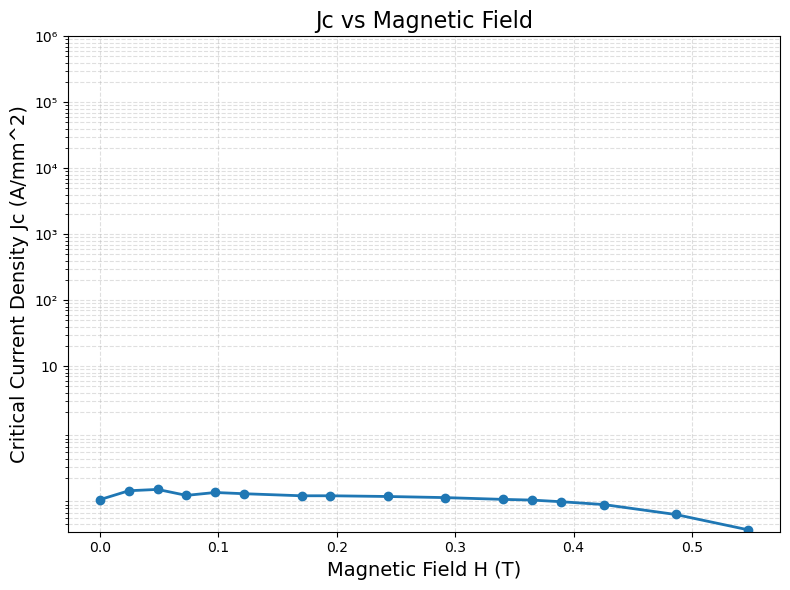

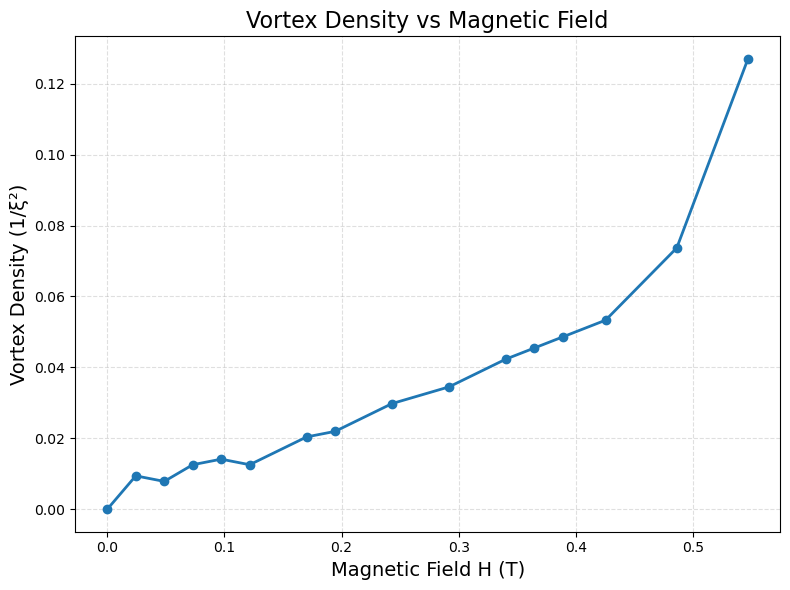


===================== VORTEX TABLE =====================
       H (T)  Vortex Count  Vortex Density (1/ξ²)
0   0.000000             0               0.000000
1   0.024308             6               0.009409
2   0.048617             5               0.007841
3   0.072925             8               0.012545
4   0.097233             9               0.014113
5   0.121541             8               0.012545
6   0.170158            13               0.020386
7   0.194466            14               0.021954
8   0.243083            19               0.029795
9   0.291699            22               0.034500
10  0.340316            27               0.042340
11  0.364624            29               0.045477
12  0.388932            31               0.048613
13  0.425395            34               0.053317
14  0.486166            47               0.073704
15  0.546936            81               0.127021

CSV saved as: TDGL_VortexCounts.csv


Validation log-RMSE = 0.1524


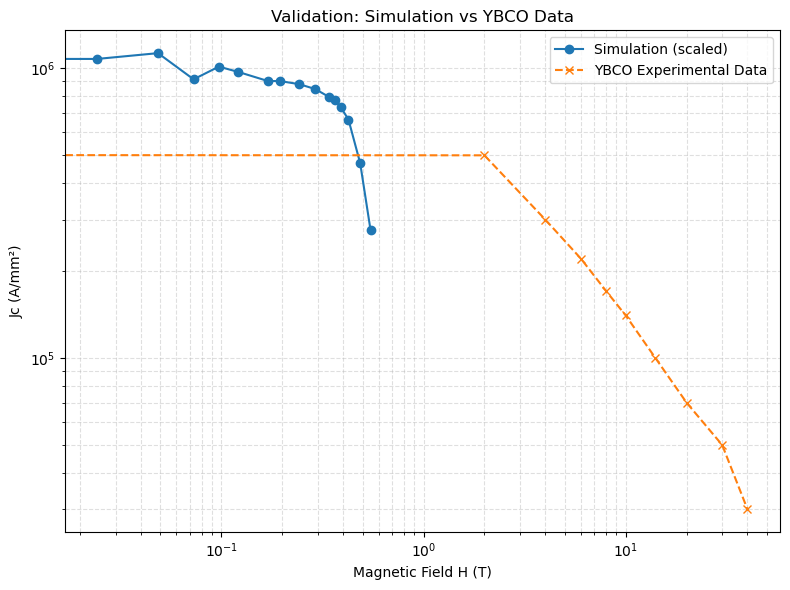

In [10]:
# --- Example Usage (currently the same as how it existed in the original version
# graphs/parameters are all the same)
if __name__ == "__main__": 
    
    # --- 1. Set Simulation Parameters ---
    n_steps = 10000
    save_interval = 1000 
    
    # --- 2. Create the Simulation Instance ---
    sim = TDGLSimulation(
        kappa=5.0,
        H=0.3,
        dt=0.005,
        resolution=100,
        vortex_seeding=False,
        evolve_A_flag=True
    )
    
    #Data Storage for History
    psi_history = []
    A_history = []
    time_points = []
    
    print("Starting Batch Simulation (replicates original script)...")
    start = time.time()
    last_save_time = start
    last_save_step = 0

    # --- 4. Run the Main Loop ---
    for step in range(n_steps):
        
        sim.update_one_step() # <-- This is the core update!
        
        if step % save_interval == 0:
            # Save data
            psi_history.append(sim.get_density()) # Store density |psi|^2
            A_history.append((sim.Ax.copy(), sim.Ay.copy()))
            t = sim.get_current_time()
            time_points.append(t)
            
            # Print status
            density = psi_history[-1]
            max_psi = np.max(np.sqrt(density))
            min_psi = np.min(np.sqrt(density))
            avg_psi = np.mean(np.sqrt(density))
            
            print(f"t={t:.1f} | |ψ|: min={min_psi:.3f}, avg={avg_psi:.3f}, max={max_psi:.3f} | Time elapsed for steps {last_save_step} to {step}: {time.time() - last_save_time:.2f}s")
            last_save_step = step
            last_save_time = time.time()
            
            # Check for instability
            if sim.check_instability():
                print("Instability detected! Stopping simulation.")
                break
                
    elapsed = time.time() - start
    print(f"\nSimulation Complete! Time: {elapsed:.2f}s")
    if time_points:
        print(f"Final time: t = {time_points[-1]:.1f}")
    else:
        print("No time points saved.")

    # --- 5. Visualization (Copied from your script) ---
    if psi_history:
        fig1, axes = plt.subplots(2, 5, figsize=(40, 12))
        fig1.suptitle('Time Evolution of |ψ|²', fontsize=16)

        for idx in range(min(10, len(psi_history))):
            ax = axes.flat[idx]
            psi_snap_density = psi_history[idx]
            
            im = ax.imshow(psi_snap_density, extent=[0, sim.Lx, 0, sim.Ly], 
                             cmap="viridis", vmin=0, vmax=1, origin='lower')
            ax.set_title(f"t = {time_points[idx]:.1f}")
            ax.set_xlabel("x (ξ)")
            ax.set_ylabel("y (ξ)")
            plt.colorbar(im, ax=ax, label='|ψ|²', fraction=0.046)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])


        # Final state analysis
        final_density = psi_history[-1]
        final_phase = sim.get_phase() # Get final phase from sim object

        fig2, axes2 = plt.subplots(1, 2, figsize=(10, 5))
        fig2.suptitle('Final state of ψ', fontsize=16)

        # Density
        im1 = axes2[0].imshow(final_density, extent=[0, sim.Lx, 0, sim.Ly], cmap="hot", 
                               vmin=0, vmax=1, origin='lower')
        axes2[0].set_title(f"|ψ|² at t={time_points[-1]:.1f}")
        axes2[0].set_xlabel("x (ξ)")
        axes2[0].set_ylabel("y (ξ)")
        plt.colorbar(im1, ax=axes2[0], label="|ψ|²")

        # Phase
        im2 = axes2[1].imshow(final_phase, extent=[0, sim.Lx, 0, sim.Ly], cmap="twilight", origin='lower')
        axes2[1].set_title("Phase of ψ")
        axes2[1].set_xlabel("x (ξ)")
        axes2[1].set_ylabel("y (ξ)")
        plt.colorbar(im2, ax=axes2[1], label="arg(ψ)")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("Simulation finished before any data was saved.")



    # Magnetic field values to sweep (same as experiment image)
    # nondimensionalize using Bc2 = Phi0 / (2*pi*xi^2)
    xi_nm = 2  # or whatever your code assumes
    Phi0 = 2.067833848e-15
    Bc2 = Phi0 / (2*np.pi*(xi_nm*1e-9)**2)

    H_values_physical = np.array([0, 2, 4, 6, 8, 10, 14, 16, 20, 24, 28, 30, 32, 35, 40, 45])
    H_values = H_values_physical / Bc2


    Jc_list = []
    vortex_count_list = []
    vortex_density_list = []

    # Relaxation settings
    relax_steps = 4000

    for H_field in H_values:

        print(f"\n======================")
        print(f"Running TDGL for H = {H_field} T")
        print("======================")

        # Create a fresh simulation for this field
        sim = TDGLSimulation(
            kappa=5.0,
            H=H_field,
            dt=0.005,
            resolution=100,
            vortex_seeding=False,
            evolve_A_flag=True
        )

        # Relaxation
        for _ in range(relax_steps):
            sim.update_one_step()
            if sim.check_instability():
                print("Instability detected; stopping early.")
                break

        # Compute Jc
        Jc = sim.compute_critical_current_density()
        Jc_list.append(Jc)

        print(f"Raw simulation Jc at H={H_field} → {Jc}")
        
        # Compute vortex statistics
        n_vortices, density = sim.count_vortices()
        vortex_count_list.append(n_vortices)
        vortex_density_list.append(density)

        print(f"H={H_field} → Jc={Jc:.5f}, vortices={n_vortices}, density={density:.4f}")
        print("\nFull Jc_list (raw simulation units):")
        print(Jc_list)

    #  data table

    df_results = pd.DataFrame({
        "Magnetic Field H (T)": H_values,
        "Critical Current Density Jc (A/mm^2)": Jc_list,
        "Number of Vortices": vortex_count_list,
        "Vortex Density (1/ξ²)": vortex_density_list
    })

    print("\n===================== RESULTS TABLE =====================")
    print(df_results)

# Save to CSV
    df_results.to_csv("TDGL_Jc_VortexData.csv", index=False)
    print("\nCSV saved as: TDGL_Jc_VortexData.csv\n")

    plt.figure(figsize=(8, 6))
    plt.plot(H_values, Jc_list, marker="o", linewidth=2)

# Log Y-axis, matching experimental style
    plt.yscale("log")
    plt.yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6],
           ["10", "10²", "10³", "10⁴", "10⁵", "10⁶"])

    plt.xlabel("Magnetic Field H (T)", fontsize=14)
    plt.ylabel("Critical Current Density Jc (A/mm^2)", fontsize=14)
    plt.title("Jc vs Magnetic Field", fontsize=16)
    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(8, 6))
    plt.plot(H_values, vortex_density_list, marker="o", linewidth=2)

    plt.xlabel("Magnetic Field H (T)", fontsize=14)
    plt.ylabel("Vortex Density (1/ξ²)", fontsize=14)
    plt.title("Vortex Density vs Magnetic Field", fontsize=16)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


    df_vortex = pd.DataFrame({
        "H (T)": H_values,
        "Vortex Count": vortex_count_list,
        "Vortex Density (1/ξ²)": vortex_density_list
    })

    print("\n===================== VORTEX TABLE =====================")
    print(df_vortex)

    df_vortex.to_csv("TDGL_VortexCounts.csv", index=False)
    print("\nCSV saved as: TDGL_VortexCounts.csv\n")

    #Data and Plots - 2

    exp_H  = np.array([0, 2, 4, 6, 8, 10, 14, 20, 30, 40])
    exp_Jc = np.array([1e6, 5e5, 3e5, 2.2e5, 1.7e5, 1.4e5, 1e5, 7e4, 5e4, 3e4])

    # Interpolate experimental curve to simulation H values
    from scipy.interpolate import interp1d
    exp_interp = interp1d(exp_H, exp_Jc, fill_value="extrapolate")
    exp_Jc_at_sim_H = exp_interp(H_values)

    cal_field = 10  # Tesla
    calibration_index = np.argmin(np.abs(H_values_physical - cal_field))
    scale_factor = exp_Jc_at_sim_H[calibration_index] / Jc_list[calibration_index]

    # Convert simulation Jc to physical units
    Jc_sim_physical = scale_factor * np.array(Jc_list)

    # Compute error metric (log-RMSE)
    error = np.sqrt(np.mean((np.log10(Jc_sim_physical) - np.log10(exp_Jc_at_sim_H))**2))
    print(f"\nValidation log-RMSE = {error:.4f}")

    # Plot comparison
    plt.figure(figsize=(8, 6))
    plt.loglog(H_values, Jc_sim_physical, 'o-', label="Simulation (scaled)")
    plt.loglog(exp_H, exp_Jc, 'x--', label="YBCO Experimental Data")
    plt.xlabel("Magnetic Field H (T)")
    plt.ylabel("Jc (A/mm²)")
    plt.title("Validation: Simulation vs YBCO Data")
    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()